In [1]:
import pandas as pd
import glob
import numpy as np
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [4]:
pwd

'C:\\Users\\nimod\\OneDrive - Université de Technologie de Troyes\\Fil_rouge'

In [5]:
glob.glob('./Tables_traitees/*')

['./Tables_traitees\\Communes_manquantes.csv',
 './Tables_traitees\\Infos_communes.csv',
 './Tables_traitees\\Infos_communes_avec_prix_estimé.csv',
 './Tables_traitees\\Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
 './Tables_traitees\\Population-Superficie_communes.csv',
 './Tables_traitees\\PrixMoy_m2_avec_code_commune.csv',
 './Tables_traitees\\Stations_carburant_avec_code_commune.csv',
 './Tables_traitees\\Stations_electriques_avec_code_commune.csv',
 './Tables_traitees\\Table_avec_prixM2_estime.csv']

| N° | Dataframe | Description |
| -- | -- | -- |  
| 1. | df_elec | Bornes électriques |
| 2. | df_carb | Stations Carburant | 
| 3. | df_pop | Population et superficie commune | 
| 4. | df_com | Infos communes | 
| 5. | df_commune_immo | Prix au m2 | 
| 6. | df_commune_adj | Communes adjacentes | |
|    | df | Dataframe regroupant pop, com, commune_immo et commune adj |
|    | df_train | =df moins 6000 valeurs, à utiliser pour l'entrainement des modèles, le reste sera pour comparer les estimations |
|    | df_m2 | =df_train filtré par les valeurs qui ont un prix au m2 |
|    | df_ridge | =df_train filtré par les valeurs qui ont un prix au m2 mais aussi filtré par les valeurs non NA de features |

In [6]:
# Lecture du fichier des tables mergées
df = pd.read_csv('./Tables_traitees/Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
                 sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
                                '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
                                '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
                                '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
                                "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
                                "4_Code Département":str })

In [7]:
# Lecture du fichier des tables mergées avec les estimations m2 déjà enregistrées
df = pd.read_csv('./Tables_traitees/Table_avec_prixM2_estime.csv',
                 sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
                                '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
                                '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
                                '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
                                "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
                                "4_Code Département":str })

In [8]:
df.shape

(36750, 62)

In [9]:
df.columns.to_list()

['3_Code région',
 '3_Nom de la région',
 '3_Code département',
 '3_Code commune',
 '3_Nom de la commune',
 '3_Population municipale',
 '3_Population comptée à part',
 '3_Population totale',
 '3_Année recensement',
 '3_Année utilisation',
 '3_Code INSEE (commune ou arrondissement)',
 '3_Superficie de la commune',
 '3_Statut',
 '3_Code EPCI',
 '3_EPCI',
 '3_Densité_hab_par_km2',
 '5_ID',
 '5_INSEE_COM',
 '5_INSEE_DEP',
 '5_INSEE_REG',
 '5_CODE_EPCI',
 '5_NOM_COM_M',
 '5_POPULATION',
 '5_Nb_Ventes',
 '5_PrixMoyen_M2',
 '5_nb_digits_code_INSEE',
 '5_code_commune_n',
 '4_Code INSEE',
 '4_Code Postal',
 '4_Commune',
 '4_Département',
 '4_Région',
 '4_Statut',
 '4_Altitude Moyenne',
 '4_Superficie',
 '4_Population',
 '4_geo_point_2d',
 '4_geo_shape',
 '4_ID Geofla',
 '4_Code Commune',
 '4_Code Canton',
 '4_Code Arrondissement',
 '4_Code Département',
 '4_Code Région',
 '4_lat',
 '4_lon',
 '4_Densité_hab_par_km2',
 '6_insee',
 '6_nom',
 '6_nb_voisins',
 '6_insee_voisins',
 '6_noms_voisins',
 

In [10]:
df.shape

(36750, 62)

In [11]:
# Valeurs uniques et manquant par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
53,6_type,object,9,35990
23,5_Nb_Ventes,float64,554,9928
24,5_PrixMoyen_M2,float64,3709,9928
57,B_Prix_estimé_vois_median,float64,9337,2351
55,A_Prix_estimé_vois_mean,float64,29371,2351
...,...,...,...,...
8,3_Année recensement,int64,10,0
9,3_Année utilisation,int64,10,0
12,3_Statut,object,2,0
1,3_Nom de la région,object,36,0


In [12]:
# correction d'une ligne (la seule, dont la superficie et la densité n'étaient pas remplies
df.loc[31441, '3_Superficie de la commune'] = 8.71
df.loc[31441, '3_Densité_hab_par_km2'] = 254.0/8.71
# df.loc[31441,:]

- Choisissons d'abord une liste d'index de 6000 valeurs
- Nous n'utiliserons pas ces lignes pour les entrainements de modèles de ML, uniquement pour mesurer la précision de chaque modèle
- SVP pour entrainer vos modèles, utiliser désormais df_train
- Ensuite vous faites la prédictions sur tout le dataframe df
- Pour la comparaison on utilisera que les lignes correspondantes aux index_to_remove, ainsi on peut comparer les résultats sur des données non entrainées

In [13]:
np.random.seed(97)
index_to_remove = np.random.randint(0,len(df)+1, size=6000)
df_train = df.drop(index_to_remove)

In [14]:
df_m2 = df_train[df_train['5_PrixMoyen_M2'].isna()==False]
# df_m2[sel_col]

In [15]:
df_m2.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

In [16]:
from sklearn.model_selection import KFold
nb_kfold = 5
rdm_state = 97
kf = KFold(n_splits=nb_kfold,shuffle=True, random_state = rdm_state)

# Estimation des manquants prix moyen m2 

On commence par choisir les variables qui vont participer à l'imputation

In [ ]:
sel_col = ['3_Code INSEE (commune ou arrondissement)','3_Code département', '5_PrixMoyen_M2', 
           'A_Prix_estimé_vois_mean', 'A_Prix_consolidé_vois_mean', 'B_Prix_estimé_vois_median', 'B_Prix_consolidé_vois_median', 
           '6_insee_voisins']

## A-Par moyenne et B-médiane des communes avoisinantes

In [ ]:
# On initialise les nouvelles variables
df['A_Prix_consolidé_vois_mean'] = np.nan
df['A_Prix_estimé_vois_mean'] = np.nan
df['B_Prix_consolidé_vois_median'] = np.nan
df['B_Prix_estimé_vois_median'] = np.nan
df['5_PrixMoyen_M2'] = df['5_PrixMoyen_M2'].astype(float)

In [ ]:
# On crée un dictionnaire pour aller plus vite dans la recherche des communes voisines 
voisins_dict = df.set_index('6_insee')['6_insee_voisins'].to_dict()
df['A_Prix_consolidé_vois_mean'] = df['5_PrixMoyen_M2']
df['B_Prix_consolidé_vois_median'] = df['5_PrixMoyen_M2']

In [ ]:
def estim_prix(code, vois, prix_mean, prix_median):
    try:
        # voisins = df_commune_adj.loc[df_commune_adj['insee']==code,'insee_voisins'].values[0].split('|')
        voisins = vois[str(code)].split('|')
        # print(voisins)
        prix_voisins_mean = list()
        prix_voisins_median = list()
        for v in voisins:
            try:
                # p = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Prix_consolidé'].values[0]
                p1 = prix_mean[str(v)]
                p2 = prix_median[str(v)]
            except:
                p1, p2 = None, None
            # nb = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Nb_Ventes'].values[0]
            prix_voisins_mean.append(float(p1))
            prix_voisins_median.append(float(p2))
        # print(code, voisins,prix_voisins)
        mean = np.nanmean(prix_voisins_mean)
        median = np.nanmedian(prix_voisins_median)
    except:
        mean = np.nan
        median = np.nan
    # print(code, mean, median)
    # print('-------')
    return pd.Series({'A_Prix_estimé_vois_mean': mean, 'B_Prix_estimé_vois_median': median})

In [ ]:
%%time
n_iterations = 10
i=0
print('iteration:',i,'nbre de manquants:', sum(pd.isna(df['A_Prix_consolidé_vois_mean'])))
while i<n_iterations:
    Prix_consolidé_dict_mean = df.set_index('3_Code INSEE (commune ou arrondissement)')['A_Prix_consolidé_vois_mean'].to_dict()
    Prix_consolidé_dict_median = df.set_index('3_Code INSEE (commune ou arrondissement)')['B_Prix_consolidé_vois_median'].to_dict()
    df[['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median']] = df.apply(lambda x: estim_prix(x['3_Code INSEE (commune ou arrondissement)'], 
                                                                                      voisins_dict, Prix_consolidé_dict_mean, 
                                                                                       Prix_consolidé_dict_median ),axis=1)
    df['A_Prix_consolidé_vois_mean'] = df['A_Prix_estimé_vois_mean']
    df['B_Prix_consolidé_vois_median'] = df['B_Prix_estimé_vois_median']
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'A_Prix_consolidé_vois_mean'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'B_Prix_consolidé_vois_median'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    nb_manquants = sum(pd.isna(df['A_Prix_consolidé_vois_mean']))
    i+=1
    print('iteration:',i,'nbre de manquants:',nb_manquants)

In [ ]:
df_prix_na = df[df['A_Prix_consolidé_vois_mean'].isna()]

In [ ]:
df_prix_na.shape

In [ ]:
print(len(df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]

In [ ]:
print(len(df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]

In [ ]:
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),'3_Code département'].unique()

2 cas pour ceux qui n'ont pas de prix consolidé
- soit ils n'ont pas de voisins identifiés
- soit ils ont des voisins mais n'ont pas de prix, en DOM TOM, départements 97X

In [ ]:
# Ceux qui n'ont pas de prix estimé parce les voisins n'en n'ont pas
df_na = df[df['A_Prix_estimé_vois_mean'].isna() & df['6_insee_voisins'].notna()]
len(df_na)
df_na[:3]

In [ ]:
print(len(df[df['5_PrixMoyen_M2'].isna()]))
print(len(df[df['A_Prix_consolidé_vois_mean'].isna()]))
print(len(df[df['B_Prix_consolidé_vois_median'].isna()]))

In [ ]:
df[df['A_Prix_estimé_vois_mean'].isna() & df['A_Prix_consolidé_vois_mean'].notna()].head()

In [ ]:
df_m2['A_Prix_estimé_vois_mean'] = df['A_Prix_estimé_vois_mean'][df['5_PrixMoyen_M2'].isna() == False]
df_m2['B_Prix_estimé_vois_median'] = df['B_Prix_estimé_vois_median'][df['5_PrixMoyen_M2'].isna() == False]

In [ ]:
df_m2.shape

## C-Par moyenne et C1-mediane de toute la variable PAUL

In [ ]:
df['5_PrixMoyen_M2'].describe()

In [ ]:
mean_value =  np.round(np.mean(df.loc[df['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
mean_value

In [ ]:
median_value = np.round(np.median(df.loc[df['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
median_value

In [ ]:
df_m2.loc[df['5_PrixMoyen_M2'].isna() == False,'C_Prix_estime_mean'] = mean_value
df_m2.loc[df['5_PrixMoyen_M2'].isna() == False,'C1_Prix_estime_median'] = median_value
df.loc[df['5_PrixMoyen_M2'].isna() == False,'C_Prix_estime_mean'] = mean_value
df.loc[df['5_PrixMoyen_M2'].isna() == False,'C1_Prix_estime_median'] = median_value
df_m2.shape

## D-Par KNN OUMAR

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Sélection des caractéristiques
features = ['3_Population municipale','5_PrixMoyen_M2', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']

# Création d'un DataFrame avec seulement les caractéristiques sélectionnées
data_subset = df[features]

# Remplacer les valeurs manquantes dans "5_PrixMoyen_M2" par NaN
data_subset['5_PrixMoyen_M2'] = data_subset['5_PrixMoyen_M2'].replace(0, np.nan)  # Assurez-vous de choisir la valeur qui représente une valeur manquante
data_subset['5_PrixMoyen_M2'] = pd.to_numeric(data_subset['5_PrixMoyen_M2'], errors='coerce')

# Imputer les valeurs manquantes avec KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data_subset)

# Normalisation des données
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_imputed)

# Créer un DataFrame avec les données normalisées et le nom des colonnes
columns = data_subset.columns
data_normalized_df = pd.DataFrame(data_normalized, columns=columns)

# Ajouter une colonne pour stocker les valeurs prédites par le KNN
data_normalized_df['0_KNN_predicted'] = imputer.transform(data_subset)[:, 1]

# Afficher toutes les données
print(data_normalized_df)


In [ ]:
df['5_PrixMoyen_M2']

In [ ]:
data_normalized_df['0_KNN_predicted']

In [ ]:
# Vérifier les valeurs manquantes dans la colonne d'origine
#missing_values_before = df['5_PrixMoyen_M2'].isnull().sum()
#print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' avant l'imputation : {missing_values_before}")

# Imputer les valeurs manquantes avec KNNImputer dans le DataFrame d'origine
#df['5_PrixMoyen_M2'] = imputer.transform(df[features])[:, 1]

# Vérifier à nouveau les valeurs manquantes après l'imputation
#missing_values_after = df['5_PrixMoyen_M2'].isnull().sum()
#print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' après l'imputation : {missing_values_after}")

In [ ]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un graphique de dispersion
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', linewidth=2)
plt.title('Valeurs Réelles vs Valeurs Prédites')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist([actual_values, predicted_values], bins=30, label=['Réel', 'Prédit'], alpha=0.7)
plt.legend()
plt.title('Histogramme des Valeurs Réelles et Prédites')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un DataFrame pour Seaborn
data_for_seaborn = pd.DataFrame({'Réel': actual_values, 'Prédit': predicted_values})

# Créer un histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=data_for_seaborn, bins=30, kde=True)
plt.title('Histogramme des Valeurs Réelles et Prédites avec Seaborn')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
Delta= y_test - Y_pred

In [ ]:
df.columns

## E-Par KNeighborsRegressor OUMAR

In [ ]:
from sklearn.neighbors import KNeighborsRegressor 

data1=df[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
data1=data1.dropna()
data2=data1.sample(n=data1.shape[0],random_state=1)


data_train= data2[:16819]
data_test= data2[16820:data1.shape[0]]

X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
y_train=data_train[['5_PrixMoyen_M2']]
X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
y_test =data_test[['5_PrixMoyen_M2']]
neigh = KNeighborsRegressor(n_neighbors=50)

neigh.fit(X_train, y_train)


In [ ]:
neigh.score(X_test,y_test)

In [ ]:
Y_pred=neigh.predict(X_test)
Delta= y_test - Y_pred


In [ ]:
Delta.describe()

## F-Par RandomForestRegressor PAUL

In [ ]:
# pd.set_option('display.max_columns', None)
df_m2.head()
# pd.reset_option('max_columns')

In [ ]:
df_verif_na = df_m2.drop(['6_type', '5_CODE_EPCI', '6_insee', '6_nom', '6_nb_voisins',
                          '6_insee_voisins', '6_noms_voisins', '6_cap_voisins'], axis=1)

In [ ]:
df_verif_na[df_verif_na.isna().any(axis=1)]

In [ ]:
df_m2.columns

In [ ]:
# from sklearn.ensemble import RandomForestRegressor 
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import make_column_selector
# from sklearn.compose import make_column_transformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import OrdinalEncoder
        
# X=df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
#              '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut', 
#              '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
X_rf = df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
             '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut']]
y_rf = df_m2[['5_PrixMoyen_M2']]

X_rf_train = X_rf.loc[:18000,:]
y_rf_train = y_rf.loc[:18000]
X_rf_test = X_rf.loc[18001:,:]
y_rf_test = y_rf.loc[18001:]

# X_rf_train = X_rf.loc[:10000,:]
# y_rf_train = y_rf.loc[:10000]
# X_rf_test = X_rf.loc[24001:,:]
# y_rf_test = y_rf.loc[24001:]

cat = ['3_Code région', '3_Code département', '3_Statut']
for c in cat:
     X_rf.loc[:,c] = X_rf.loc[:,c].astype(object)

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
print(cat_selector(X_rf))
print(num_selector(X_rf))

In [ ]:
X_rf.shape

In [ ]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

In [ ]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=0, n_jobs = -1))
rf_pipeline

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
# param_grid = {
#     # 'randomforestregressor__n_estimators': [100, 200, 300, 400],
#     'randomforestregressor__max_depth': [15, 30, 35],
#     'randomforestregressor__max_features': [2, 3, 4],
#     # 'randomforestregressor__min_samples_leaf': [2, 3, 4, 5],
#     'randomforestregressor__min_samples_split': [10, 12, 14]
# }

# grid_search = GridSearchCV(
#     rf_pipeline,
#     param_grid=param_grid,
#     scoring='r2',  # Choisissez la métrique appropriée
#     cv=kf
# )

# grid_search.fit(X_rf_train, y_rf_train.values.ravel())

# # Afficher les meilleurs paramètres
# print("Meilleurs paramètres:", grid_search.best_params_)

# # Évaluer la performance du modèle sur les données de test
# test_score = cross_val_score(grid_search.best_estimator_, X_rf_test, y_rf_test.values.ravel(), cv=kf, scoring='r2')
# print("Performance sur les données de test:", test_score.mean())

In [ ]:
# y_pred = grid_search.best_estimator_.predict(X_rf_test)
# print(grid_search.best_estimator_.score(X_rf_test, y_rf_test.values.ravel()))
# sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# depth = grid_search.cv_results_['param_randomforestregressor__max_depth'].data
# features = grid_search.cv_results_['param_randomforestregressor__max_features'].data
# split = grid_search.cv_results_['param_randomforestregressor__min_samples_split'].data
# results = grid_search.cv_results_['mean_test_score']
# sns.pointplot(x=depth, y=results)

In [ ]:
# sns.pointplot(x=features, y=results)

In [ ]:
# sns.pointplot(x=split, y=results)

In [ ]:
# grid_search.cv_results_['mean_test_score']

In [ ]:
# rf_pipeline_test = make_pipeline(tree_preprocessor, RandomForestRegressor(max_depth=15, random_state=0, n_jobs = -1))
# rf_pipeline_test.fit(X_rf_train, y_rf_train.values.ravel())
# rf_pipeline_test.score(X_rf_test, y_rf_test.values.ravel())

# y_pred = rf_pipeline_test.predict(X_rf_test)

# sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
# rf_pipeline.get_params().keys()

In [ ]:
l_profondeur = np.arange(5, 30, 5)
rf_score = []

for train, test in kf.split(X_rf):
    X_train = X_rf.iloc[train,:]
    y_train = y_rf.iloc[train]
    X_test = X_rf.iloc[test,:]
    y_test = y_rf.iloc[test]
    
    for prof in l_profondeur:
        rf_pipeline.set_params(**{'randomforestregressor__max_depth':prof})
        # rf = make_pipeline(RandomForestRegressor(max_depth=prof, random_state=0, n_jobs = 10))
        rf_pipeline.fit(X_train, y_train.values.ravel())
        rf_score.append(rf_pipeline.score(X_test, y_test.values.ravel()))

res_rf_score = np.reshape(rf_score, [nb_kfold, l_profondeur.shape[0]])
res_rf_score = np.mean(res_rf_score, axis = 0)
indice_max = np.unravel_index(np.argmax(res_rf_score), res_rf_score.shape)
print('Indices Best score :', indice_max)
print('Best score :', np.max(res_rf_score))
print('Profondeur best score :', l_profondeur[indice_max])
# data2=data1.sample(n=data1.shape[0],random_state=1)


# data_train= data2[:16819]
# data_test= data2[16820:data1.shape[0]]

# X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_train=data_train[['5_PrixMoyen_M2']]
# X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_test =data_test[['5_PrixMoyen_M2']]
# rf = RandomForestRegressor(max_depth=20, random_state=0)

# rf.fit(X_train, y_train)


In [ ]:
sns.pointplot(x=l_profondeur, y=res_rf_score)

In [ ]:
rf_pipeline.set_params(**{'randomforestregressor__max_depth':l_profondeur[indice_max]})
rf_pipeline.fit(X_rf_train, y_rf_train.values.ravel())

Y_pred_rf=rf_pipeline.predict(X_rf_test)
rf_pipeline.score(X_rf_test, y_rf_test.values.ravel())

In [ ]:
# sns.pointplot(x=Y_pred_rf, y=y_rf_test.values.ravel())

In [ ]:
# rf.score(X_test,y_test)

In [ ]:
# Y_pred_rf=rf.predict(X_test)
# Delta_rf= y_test['5_PrixMoyen_M2'] - Y_pred_rf
# Delta_rf.describe()

In [ ]:
# Y_pred_rf.shape

In [ ]:
# Y_pred[0:]

In [ ]:
# y_test['5_PrixMoyen_M2']

In [ ]:
# y_test.shape

In [ ]:
# Y_pred=rf.predict(X_test)

In [ ]:
# y_test

In [ ]:
df['F_Prix_estimé_RFReg'] = np.nan
features_RF = ['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
             '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut']
df.loc[df[features_RF].notna().all(axis=1),'F_Prix_estimé_RFReg'] = rf_pipeline.predict(df.loc[df[features_RF].notna().all(axis=1),features_RF])

In [ ]:
df.loc[:50,['5_PrixMoyen_M2','F_Prix_estimé_RFReg']]

-------------------------------

## RF Regressor sans encoding simplifié

In [74]:
df.shape

(36750, 63)

In [75]:
df_train.shape

(31250, 62)

In [76]:
df_m2.shape

(22801, 62)

In [77]:
# Sélection des caractéristiques
features_RF2 = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [78]:
df['4_Département'].unique().tolist()

['AIN',
 'AISNE',
 'ALLIER',
 'ALPES-DE-HAUTE-PROVENCE',
 'HAUTES-ALPES',
 'ALPES-MARITIMES',
 'ARDECHE',
 'ARDENNES',
 'ARIEGE',
 'AUBE',
 'AUDE',
 'AVEYRON',
 'BOUCHES-DU-RHONE',
 'CALVADOS',
 nan,
 'CANTAL',
 'CHARENTE',
 'CHARENTE-MARITIME',
 'CHER',
 'CORREZE',
 "COTE-D'OR",
 "COTES-D'ARMOR",
 'CREUSE',
 'DORDOGNE',
 'DOUBS',
 'DROME',
 'EURE',
 'EURE-ET-LOIR',
 'FINISTERE',
 'CORSE-DU-SUD',
 'HAUTE-CORSE',
 'GARD',
 'HAUTE-GARONNE',
 'GERS',
 'GIRONDE',
 'HERAULT',
 'ILLE-ET-VILAINE',
 'INDRE',
 'INDRE-ET-LOIRE',
 'ISERE',
 'JURA',
 'LANDES',
 'LOIR-ET-CHER',
 'LOIRE',
 'HAUTE-LOIRE',
 'LOIRE-ATLANTIQUE',
 'LOIRET',
 'LOT',
 'LOT-ET-GARONNE',
 'LOZERE',
 'MAINE-ET-LOIRE',
 'MANCHE',
 'MARNE',
 'HAUTE-MARNE',
 'MAYENNE',
 'MEURTHE-ET-MOSELLE',
 'MEUSE',
 'MORBIHAN',
 'MOSELLE',
 'NIEVRE',
 'NORD',
 'OISE',
 'ORNE',
 'PAS-DE-CALAIS',
 'PUY-DE-DOME',
 'PYRENEES-ATLANTIQUES',
 'HAUTES-PYRENEES',
 'PYRENEES-ORIENTALES',
 'BAS-RHIN',
 'HAUT-RHIN',
 'RHONE',
 'HAUTE-SAONE',
 'SAONE-ET-L

In [79]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']
cat_features = ['4_Département']
for c in cat_features:
    df[c] = df[c].astype('category')
    df_train[c] = df_train[c].astype('category')

In [80]:
df_ridge = df_train[df_train[features_RF2].notna().all(axis=1) & df_train['5_PrixMoyen_M2'].notna()]
df_ridge.shape

(22798, 62)

In [81]:
y = df_ridge['5_PrixMoyen_M2']
X = df_ridge[features_RF2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X[features_RF2].head()

,3_Population municipale,3_Densité_hab_par_km2,3_Superficie de la commune,4_Altitude Moyenne,4_lat,4_lon
1,243.0,26.615553,9.13,483.0,46.009188,5.428017
4,110.0,18.242123,6.03,589.0,45.749499,5.594320
5,2684.0,79.904734,33.59,309.0,46.005591,5.357607
7,336.0,48.206600,6.97,294.0,45.787357,5.657883
8,1124.0,38.114615,29.49,706.0,45.909372,5.795160


In [83]:
X.dtypes

3_Population municipale       float64
3_Densité_hab_par_km2         float64
3_Superficie de la commune    float64
4_Altitude Moyenne            float64
4_lat                         float64
4_lon                         float64
dtype: object

In [84]:
%%time
rf = Pipeline(
    steps=[
        ("RandomForest", RandomForestRegressor(max_depth=15, random_state=0))])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

CPU times: total: 16.1 s
Wall time: 24.7 s


In [85]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

mse 261702.38700929048
r2 0.6196001837606933


In [86]:
df['F_Prix_estimé_RFReg2'] = np.nan
df.loc[df[features_RF2].notna().all(axis=1),'F_Prix_estimé_RFReg2'] = rf.predict(df.loc[df[features_RF2].notna().all(axis=1),features_RF2])

In [87]:
df.loc[:50,['5_PrixMoyen_M2','F_Prix_estimé_RFReg2']]

,5_PrixMoyen_M2,F_Prix_estimé_RFReg2
0,1938.0,1671.362469
1,1130.0,1373.047803
2,2005.0,2914.367866
3,2442.0,2352.671366
4,1155.0,1289.164813
5,1963.0,1982.354819
6,1940.0,2050.619224
7,966.0,2040.083831
8,1970.0,1948.625364
9,889.0,1273.803267


-------------------------------

## G-Par Bayesian Ridge NICOLAS

In [18]:
# Sélection des caractéristiques
features = ['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [22]:
deltadf_ridge_m2 = df_m2[df_m2[features].isna().any(axis=1)]
deltadf_ridge_m2

,3_Code région,3_Nom de la région,3_Code département,3_Code commune,3_Nom de la commune,3_Population municipale,3_Population comptée à part,3_Population totale,3_Année recensement,3_Année utilisation,...,6_cap_voisins,6_type,A_Prix_consolidé_vois_mean,A_Prix_estimé_vois_mean,B_Prix_consolidé_vois_median,B_Prix_estimé_vois_median,C_Prix_estime_mean,C1_Prix_estime_median,F_Prix_estimé_RFReg,G_Prix_estimé_LassoCV
21385,44.0,Grand Est,55,138.0,Culey,146.0,3.0,149.0,2016,2019,...,15|74|100|168|187|205|238|290|328,NaN,972.0,972.081118,972.0,1076.0000,1636.0,1450.0,1340.721902,NaN
30942,28.0,Normandie,76,95.0,Bihorel,8301.0,186.0,8487.0,2016,2019,...,64|227|330,NaN,2076.0,2578.666667,2076.0,2596.0000,1636.0,1450.0,2639.929309,NaN
31441,28.0,Normandie,76,601.0,Saint-Lucien,252.0,2.0,254.0,2016,2019,...,43|119|209|246|318,commune,1548.0,1445.800000,1548.0,1618.3125,1636.0,1450.0,1570.707589,NaN


In [ ]:
# En fait df_ridge a 3 lignes en moins que df_m2 car d'autres features manquent

In [ ]:
df_ridge = df_train[df_train[features].notna().all(axis=1) & df_train['5_PrixMoyen_M2'].notna()]
df_ridge

In [ ]:
df_ridge.shape

In [ ]:
y = df_ridge['5_PrixMoyen_M2']
X = df_ridge[['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']
cat_features = ['4_Département']

for c in cat_features:
    X[c] = X[c].astype('category')

In [ ]:
X.dtypes

In [ ]:
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()),
    ])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))
          ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ])

In [ ]:
%%time
lasso_opti= Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("lassoCV", LassoCV(cv=5, random_state=0))])#BayesianRidge())]) #
lasso_opti.fit(X_train, y_train)
y_pred = lasso_opti.predict(X_test)

In [ ]:
lasso_opti.named_steps.lassoCV.alphas_

In [ ]:
lasso_opti.named_steps.lassoCV.alpha_

In [ ]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

In [ ]:
df.loc[df[features].isna().any(axis=1),features]

In [ ]:
features

In [ ]:
df['G_Prix_estimé_LassoCV'] = np.nan
df.loc[df[features].notna().all(axis=1),'G_Prix_estimé_LassoCV'] = lasso_opti.predict(df.loc[df[features].notna().all(axis=1),['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']])

In [ ]:
df.loc[:40,['5_PrixMoyen_M2', 'G_Prix_estimé_LassoCV'] ]

## Sauvegarde des datas

In [ ]:
df.columns

In [50]:
# df.to_csv('./Tables_traitees/Table_avec_prixM2_estime.csv', index=False, sep=';')

## Comparaison des différents du prix moyen au m2 NICOLAS

In [88]:
# Valeurs uniques par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

,Variable,type,Nb_val_unique,Nb_manquant
53,6_type,object,9,35990
23,5_Nb_Ventes,float64,554,9928
24,5_PrixMoyen_M2,float64,3709,9928
57,B_Prix_estimé_vois_median,float64,9337,2351
55,A_Prix_estimé_vois_mean,float64,29371,2351
...,...,...,...,...
8,3_Année recensement,int64,10,0
9,3_Année utilisation,int64,10,0
12,3_Statut,object,2,0
1,3_Nom de la région,object,36,0


In [89]:
def performance_of_simulations(titre, list_of_sim):

    list_of_col = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal']
    
    print(f"{'RAPPEL: Nombre de prix moyen total / manquants:':50} {len(df)} / {len(df[df['5_PrixMoyen_M2'].isna()])}")
    
    plt.figure(figsize=(15,3.5*len(list_of_sim)))
    plt.suptitle(titre)
    
    for i,p in enumerate(list_of_sim):
        
        print(f"{'Simulation:':50} {p}")
        print(f"{'Nombre de prix estimés:':50} {len(df[df[p].notna()])}")

        df_eval = df.loc[index_to_remove,:].copy()
        df_not_NA = df_eval[(df_eval[p].notna()) & df_eval['5_PrixMoyen_M2'].notna()].copy()
        # df_not_NA = df[(df[p].notna()) & df['5_PrixMoyen_M2'].notna()].copy()
        print(f"{'Nombre de prix pour la comparaison:':50} {len(df_not_NA)}")
        
        mse = mean_squared_error( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        r2 = r2_score( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        
        df_not_NA['Delta_PrixMoyen_VS_estimé'] = df_not_NA[p] - df_not_NA['5_PrixMoyen_M2']

        plt.subplot(len(list_of_sim),3,3*i+1)
        sns.scatterplot(data=df_not_NA, x='5_PrixMoyen_M2', y=p, color=list_of_col[i])
        sns.lineplot(x=[0,10000], y=[0,10000],color='r')
        top = plt.gca().get_ylim()[1]
        plt.text(0, top-1000, s=p)
        plt.text(0,top-2000,s=f"mse: {round(mse)}")
        plt.text(0,top-3000,s=f"r2: {round(r2,3)}")
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('5_PrixMoyen_M2')

        plt.subplot(len(list_of_sim),3,3*i+2) 
        sns.histplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'], color=list_of_col[i])
        plt.xlim(-3000,3000)
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')

        plt.subplot(len(list_of_sim),3,3*i+3)
        sns.boxplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'],orient='h', color=list_of_col[i])
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')
        print('Analyse de l"écart entre Prix Moyen réel et prix estimé')
        print(df_not_NA['Delta_PrixMoyen_VS_estimé'].describe()) #
    plt.savefig("Comparaison des estimations du prix au M2.png")
    plt.show()
    

RAPPEL: Nombre de prix moyen total / manquants:    36750 / 9928
Simulation:                                        A_Prix_estimé_vois_mean
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean       -2.923004
std       449.353243
min     -3879.429164
25%      -188.839996
50%        25.000000
75%       226.633333
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:                                        B_Prix_estimé_vois_median
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean      -34.577739
std       448.811375
min     -4083.000000
25%      -197.500000
50%         0.000000
75%       190.000000
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:   

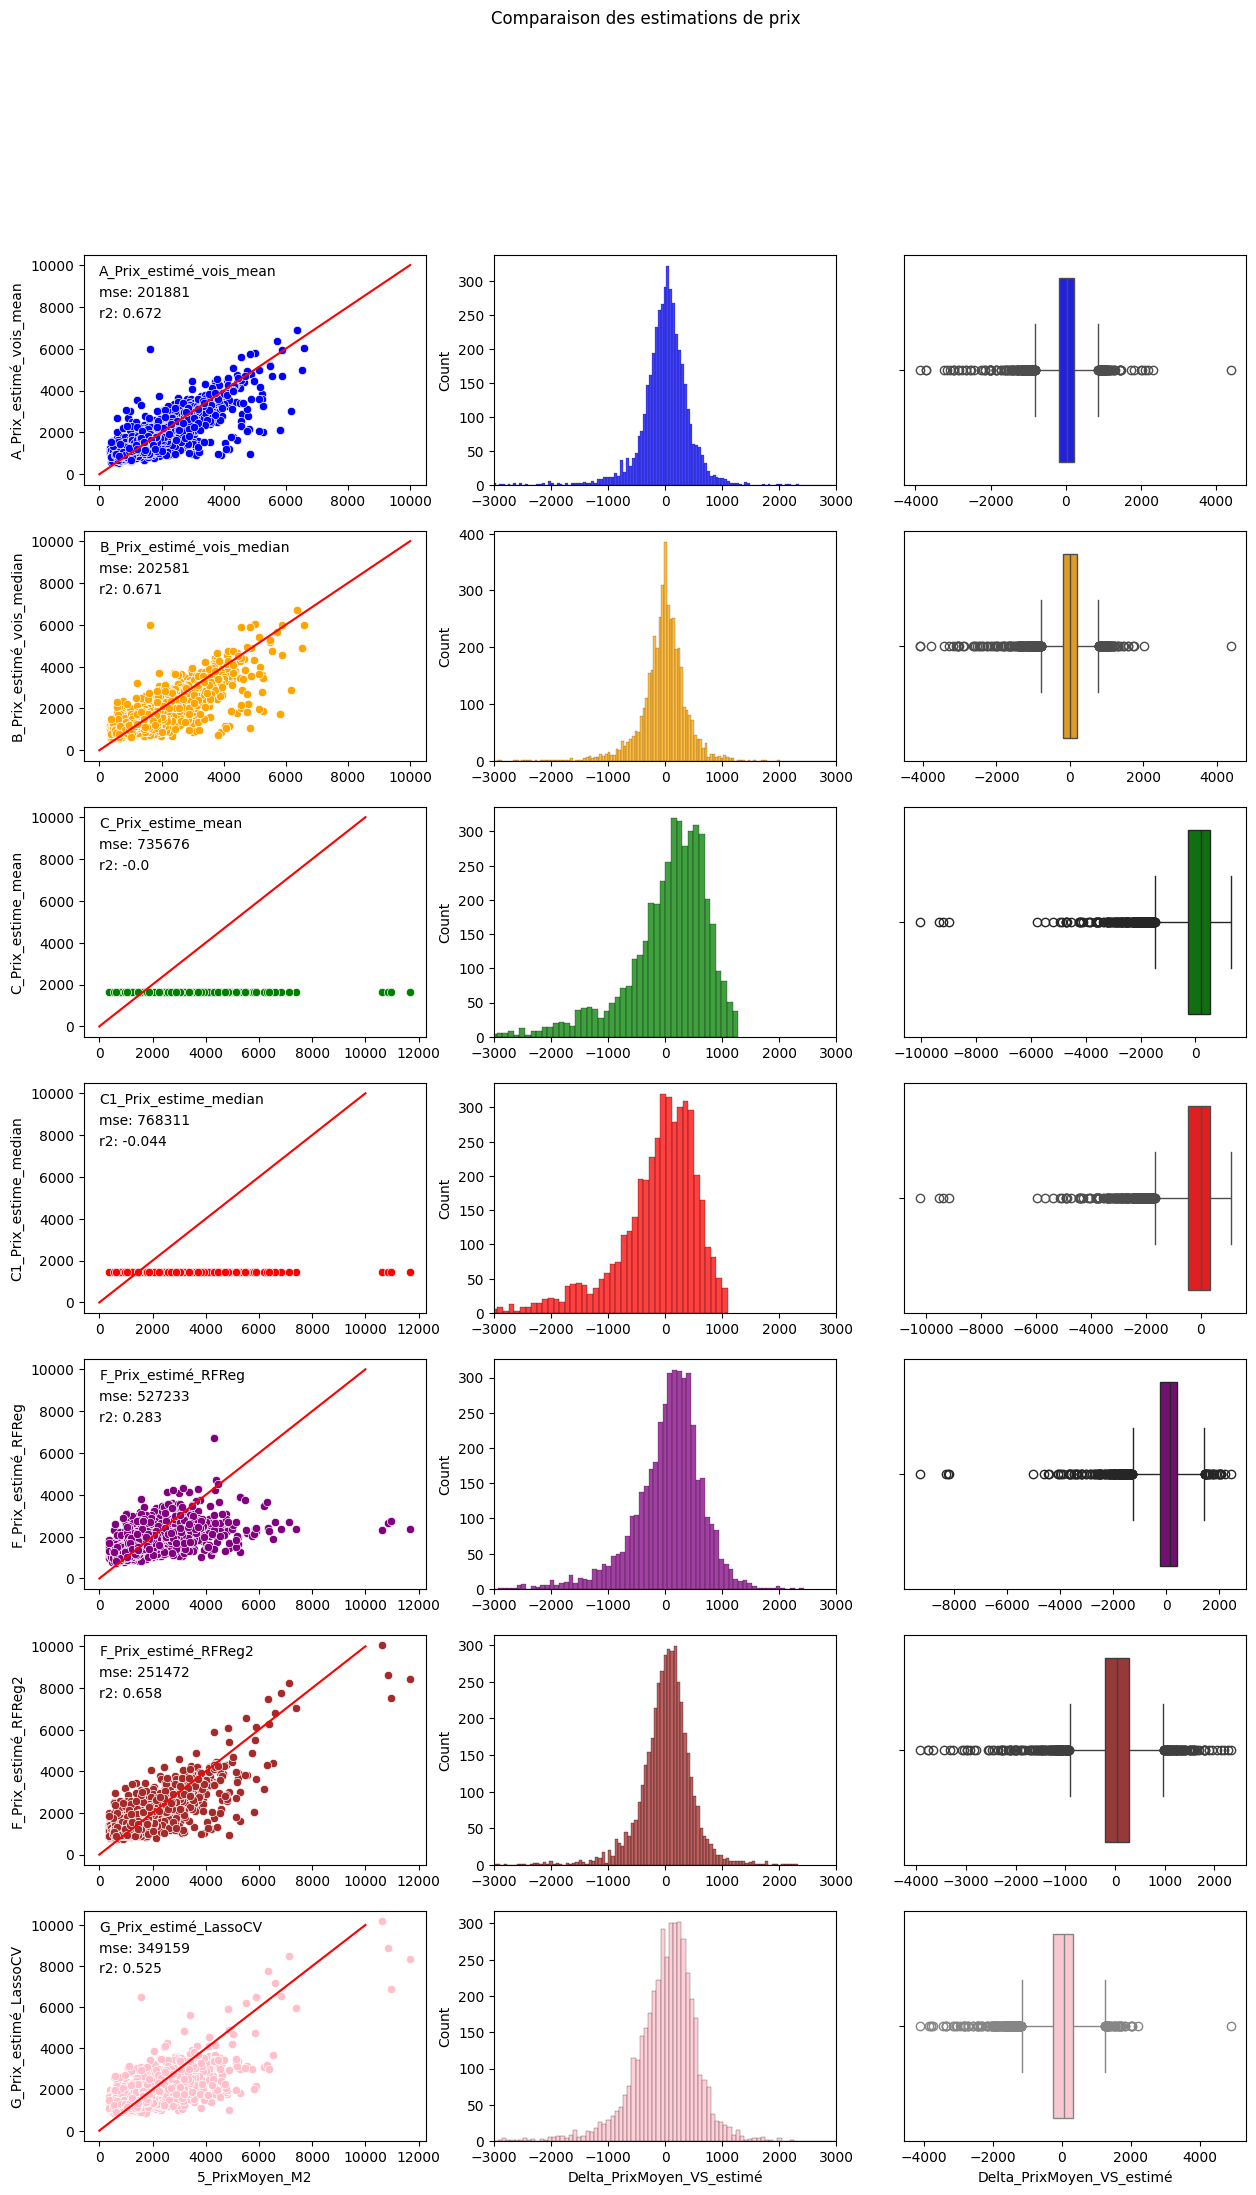

In [90]:
performance_of_simulations('Comparaison des estimations de prix',  
                           ['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median', 
                            'C_Prix_estime_mean', 'C1_Prix_estime_median',
                            'F_Prix_estimé_RFReg',  'F_Prix_estimé_RFReg2',
                            'G_Prix_estimé_LassoCV',
                           ])